<a href="https://colab.research.google.com/github/ssnirgudkar/UNet/blob/main/IR_7classes_Unet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. no of classes if mentioned 3, then the labels **can only** have values of 0,1 and 2
2. You can check the actual error using CPU, and not GPU
3. softmax is good for image segmentation. it's a probablistic algorithm, so the losses also haev to be accordingly. all of the below are with softmax activation. optimizers are changed in the middle.  
4. relu / leakyrelu, adam will work 
5. **Option 1-** leakyrelu - epoc 50, 62 images of which validation images 3. batch size 3 , kernel_initializer = 'he_normal'- , leakyrelu, sparse_categorical_crossentropy, optimizer - rmsprop: val_loss went from 87 to 0.2. But it was not continually reducing and was fluctutating.  Output segmentation was good. obstacles were showing up.
6. **Option 2- **RELU, epoc 50, total images - 62, validation 3 images, sparse_categorical_crossentropy, kernel_initializer = 'he_normal', optimizer = rmsprop: Val_loss started from 127 and went to 0.08. was better converging than option 1, but still not always decreasing. Image output better than option 1
7. Option 3: **RELU, epoc 50, total images - 62, validation 3 images, sparse_categorical_crossentropy, kernel_initializer = 'he_normal', optimizer = adam, defalt learn rate(lr): Val_loss started from 45 and went to 0.0528. The val loss continually decreased and converged. Image output better than option 1 and 2. Observations - reflection in water is shown as an obstacle. Bits of water are shown as cloud
8. Option 4: **RELU, epoc 50, total images - 62, validation 3 images, categorical_crossentropy, kernel_initializer = 'he_normal', optimizer - adam, lr = 0.01: Val_loss started from 476 billion  and went to NAN in the 6th apoch. No segmentation output available. it was all black. Tried to change the loss to sparse_categorical_crossentropy with the same lr - 0.01, but the op was worse than that with default lr = 0.001  
Kept the loss to sparse_categorical_crossentropy , but changed the lr to 0.005. That works comparable to lr = 0.001(default), but a touch lower. Some images are at par with default lr, some are not.   
9. adam, lr = 0.001(default), softmax, kernel_initializer = 'uniform'. val_loss starts from 2.4 to 0.06. Some images with this are better than those using he_normal. 
**Recommendation - adam, sparse_categorical_crossentropy, relu, lr=. default = 0.001, kernal initilizer = 'he_normal' OR kernal initilizer = 'uniform'**

Training results - 
1. Ran with 291 IR images (including night _ pilot IR. Mirror images of those + labeled) = 882 images in this directory. The checkpoint file is IR_1000images_uniform_adam_softmax_100_10.h5. Indictes, it was run for 1000 images, uniform kernel initializer, adam optimizer, softmax algo, 100 epochs with a batch size of 10. No of classes are 4 (0 thru 3). This was run with TPU. Per Epoc (86 batches with a batch size of 10 - estimate time was 10 min). Val_loss for epoc 1 was 5.0147 although average loss was 0.3 for each batch. Then ran with GPU to see which one to go with. GPU checking the unique label value took lot of time for 800 images. However, the training time - 1 epoch 1st batch with 86 batches with a batch size of 10 - estimate was only 2 min. Val loss was 7 although loss was 0.1. So GPU was much faster for training than TPU.Also TPU libraries to be imported change, plus TPU gives verbose explanbation of error as against GPU that just says NAN

Results - IMP - numbering, and number of images shoild be exactly same between image and masks. The algo sorts it and uses it one to one. else we will see very bad losses and bad inference. 
Epoch 25/25
837/837  - 188s 224ms/step - loss: 0.0197 - val_loss: 0.0206

# Now i save model from run1, and use that saved model to restart training in run2. so each time i run, the model is getting retrained. i need to be careful that if i am running a test (w/o good data), i shld not save the model, else it will corrupt the earlier learning. 

# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [1]:
import tensorflow as tf
print("keras version is", tf.keras.__version__)
print ("tf version is", tf.__version__) 
!python --version

keras version is 2.6.0
tf version is 2.6.0
Python 3.7.11


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#!cd "drive/My Drive/PhD/IRLabeledDataset"

Mounted at /content/drive


## Prepare paths of input images and target segmentation masks

In [ ]:
'''this is a test code to check syntax 
flag = 0 
ideal_label_array = [0,1,2,3]
target_label_array = [0,1,2,3,5]
if(set(target_label_array).issubset(set(ideal_label_array))):
  flag = 0
else:    
  flag = 1 
  print("Error in label", target_label_array ) 
'''

In [4]:
import os
import numpy as np
import cv2

'''
older ir images from shailesh's drive
input_dir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized" # directory containing input images
target_dir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized_relabel_only3wasrclasses" # directory containing segmented images

input_dir = "/content/drive/MyDrive/IRImageTrainingDataset/ir_train_images_resized_colored_291_images" # directory containing input images
target_dir = "/content/drive/MyDrive/IRImageTrainingDataset/ir_train_masks_resized_relabeled_291_images" # directory containing segmented images
'''

input_dir = "/content/drive/MyDrive/IRImages_7classes_unet" # directory containing 8000 IR input images
target_dir = "/content/drive/MyDrive/IRImages_7classes_masks_unet" # directory containing 8000 segmented IR images

img_size = (256, 320) #it's height and width. it's a 1/2 sized image from the original image from segment.ai
num_classes = 7
batch_size = 10

# check for distinct label values in all masked files 

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

#prints how many files are in the batch
print("Number of samples:", len(input_img_paths))
print("Number of samples:", len(target_img_paths))

#prints the name of 10 sets of input and labeled file
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

'''
COMMENTING THIS CODE AS THE CHECK HAS ALREADY BEEN DONE DURING PREPROCESSING
#below code checks if the labels are in the 1 through 3 range (4 classes - sky,water,object,background). 
#Because if not, then model training gives a NAN error.
#it displays the label file that has an error, and the values of the label
ideal_label_array = [0,1,2] # depends on the number of classes
flag = 0 
for target_path in (target_img_paths):
    target_label_array = (np.unique(cv2.imread(target_path,cv2.IMREAD_UNCHANGED)))
    if(set(target_label_array).issubset(set(ideal_label_array))):
       flag +=1
       #print("good label", flag)
    else:    
       flag +=1
       print("Error in label", flag,target_path,target_label_array )  

'''

Number of samples: 8874
Number of samples: 8874
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_31.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_31.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_32.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_32.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_33.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_33.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_34.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_34.png
/content/drive/MyDri

'\nCOMMENTING THIS CODE AS THE CHECK HAS ALREADY BEEN DONE DURING PREPROCESSING\n#below code checks if the labels are in the 1 through 3 range (4 classes - sky,water,object,background). \n#Because if not, then model training gives a NAN error.\n#it displays the label file that has an error, and the values of the label\nideal_label_array = [0,1,2] # depends on the number of classes\nflag = 0 \nfor target_path in (target_img_paths):\n    target_label_array = (np.unique(cv2.imread(target_path,cv2.IMREAD_UNCHANGED)))\n    if(set(target_label_array).issubset(set(ideal_label_array))):\n       flag +=1\n       #print("good label", flag)\n    else:    \n       flag +=1\n       print("Error in label", flag,target_path,target_label_array )  \n\n'

## What does one input image and corresponding segmentation mask look like?

In [5]:
import cv2
import tensorflow
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import PIL

img = cv2.imread('/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2.png')
print(img) 
img1 = cv2.imread('/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2.png', cv2.IMREAD_UNCHANGED)
print(img1)
print(img.shape) # height , width, color
print(img1.shape)
array1 = tensorflow.keras.preprocessing.image.img_to_array(img)
print(array1) 
array2 = tensorflow.keras.preprocessing.image.img_to_array(img1)
print(array2) 
print(np.unique(array1))
print(np.unique(array2))
print(tensorflow.keras.backend.epsilon())
print(np.unique(cv2.imread('/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2.png')))
print(np.unique(cv2.imread('/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2.png',cv2.IMREAD_UNCHANGED)))


[[[ 19  19  19]
  [ 18  18  18]
  [ 18  18  18]
  ...
  [ 18  18  18]
  [ 20  20  20]
  [ 10  10  10]]

 [[ 35  35  35]
  [ 34  34  34]
  [ 35  35  35]
  ...
  [ 37  37  37]
  [ 36  36  36]
  [ 18  18  18]]

 [[ 34  34  34]
  [ 32  32  32]
  [ 33  33  33]
  ...
  [ 36  36  36]
  [ 35  35  35]
  [ 18  18  18]]

 ...

 [[102 102 102]
  [102 102 102]
  [108 108 108]
  ...
  [109 109 109]
  [107 107 107]
  [ 53  53  53]]

 [[107 107 107]
  [106 106 106]
  [107 107 107]
  ...
  [106 106 106]
  [106 106 106]
  [ 54  54  54]]

 [[109 109 109]
  [110 110 110]
  [109 109 109]
  ...
  [106 106 106]
  [106 106 106]
  [ 53  53  53]]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(256, 320, 3)
(256, 320)
[[[ 19.  19.  19.]
  [ 18.  18.  18.]
  [ 18.  18.  18.]
  ...
  [ 18.  18.  18.]
  [ 20.  20.  20.]
  [ 10.  10.  10.]]

 [[ 35.  35.  35.]
  [ 34.  34.  34.]
  [ 35.  35.  35.]
  ...
  [ 37.  37.  37.]
  [ 36.  36.  36.]
  

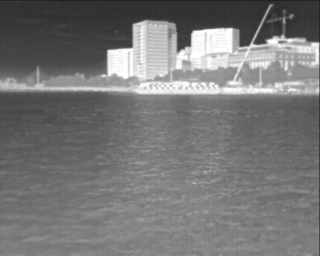

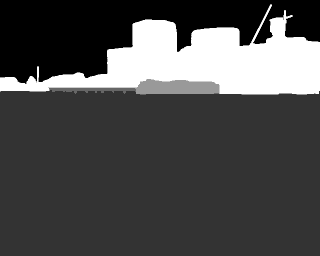

In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #9
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            #in case we want to see if masked image have the right values
            #print(tensorflow.keras.preprocessing.image.img_to_array(img))
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2: 
            #if classes are 3, keras expects masked values to be 0,1,2 only. Cannot take 1,3,5. It checks numerically not just the number of masked values
            #y[j] += 1 
        return x, y


## Prepare U-Net Xception-style model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2 ,padding="same",kernel_initializer = 'uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("ReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'uniform')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("ReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'uniform')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same", )(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same",  kernel_initializer = 'uniform')(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("ReLU")(x)
        x = layers.Conv2DTranspose(filters, 3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("ReLU")(x)
        x = layers.Conv2DTranspose(filters, 3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1,padding="same", kernel_initializer = 'uniform')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same",kernel_initializer = 'uniform')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

## Set aside a validation split

In [9]:
import random

# Split our img paths into a training and a validation set. There are 8000 images in the input. 
val_samples = 500
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [10]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

import tensorflow as tf
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)

#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    #commenting checkpoint because i am going to save the entire model and start with earlier model
    #keras.callbacks.ModelCheckpoint("IR_1000images_he_normal_adam_softmax_relu_300_10_1.h5", save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

# Train the model, doing validation at the end of each epoch. This will be the first time code. Thereafter, you first load the saved model and then train again
epochs = 25
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# Save the model after training 
model.save("/content/drive/MyDrive/Models/UNet_7classes_1.0")

 




/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/25
837/837 [==============================] - 5085s 6s/step - loss: 0.2189 - val_loss: 0.1571
Epoch 2/25
837/837 [==============================] - 181s 216ms/step - loss: 0.0940 - val_loss: 0.6622
Epoch 3/25
837/837 [==============================] - 187s 223ms/step - loss: 0.0677 - val_loss: 0.0587
Epoch 4/25
837/837 [==============================] - 187s 224ms/step - loss: 0.0634 - val_loss: 0.1387
Epoch 5/25
837/837 [==============================] - 187s 223ms/step - loss: 0.0698 - val_loss: 0.0478
Epoch 6/25
837/837 [==============================] - 187s 223ms/step - loss: 0.0427 - val_loss: 0.0408
Epoch 7/25
837/837 [==============================] - 187s 223ms/step - loss: 0.0617 - val_loss: 0.0626
Epoch 8/25
837/837 [==============================] - 187s 223ms/step - loss: 0.0423 - val_loss: 0.0372
Epoch 9/25
837/837 [==============================] - 186s 223ms/step - loss: 0.0347 - val_loss: 0.0346
Epoch 10/25
837/837 [==============================] - 187s 223ms/

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/UNet_7classes_1.0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/UNet_7classes_1.0/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Train the Model - Run 2

In [ ]:
# after the 1st run, we can just run from this step on (excluding the files etc)

# now load the model for the next run 
import tensorflow as tf
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/UNet_7classes_1.0")

# now re-train on the saved model - this will be from run2
epochs = 50
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
reconstructed_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# now save the model back ### REMEMBER : ONLY save the model if you know your run is with good data. 
# ELSE it will spoil all the prior learning. Will save the new model in a different folder so that it doesn't spoil the 
# original model. will run in batches of Epochs. 
reconstructed_model.save("/content/drive/MyDrive/Models/UNet_7classes_temp")

## Visualize predictions

In [ ]:
print(val_input_img_paths)
print(val_target_img_paths)
print(type(val_input_img_paths))

this is the raw image


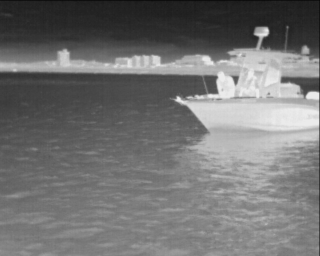

this is the labeled image


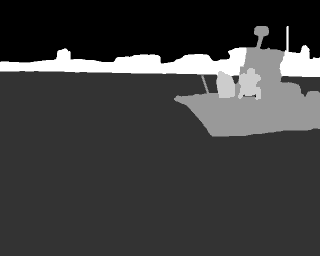

(256, 320, 1)
1
320
<class 'PixelAccess'>
(0, 0, 0)
this is the colored inferred image


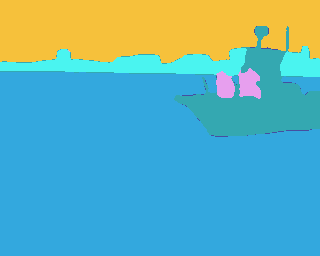

this is the gray inferred image


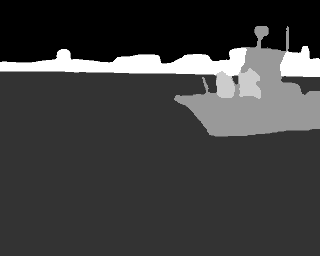

In [14]:
# Generate predictions for all images in the validation set

from IPython.display import Image, display
import PIL
from PIL import ImageOps
#from PIL import Image

#val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
#val_input_img_paths_test = ['/content/drive/MyDrive/poorlighting_brightlight_resized/1603208980.690948_resized.png']
val_input_img_paths_test = ['/content/drive/MyDrive/IRImages_7classes_unet/1571161440.714693_1_2.png']
val_target_img_paths_test = ['/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161440.714693_1_2.png']


#print(type(val_input_img_paths_test))

val_gen = OxfordPets(1, img_size, val_input_img_paths_test, val_target_img_paths_test)
# we will use model for the 1st run. and then reconstructed_model from run 2
#val_preds = model.predict(val_gen)

#predict using the saved model - run 2 on 
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/UNet_7classes_1.0")
val_preds = reconstructed_model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction. we need color masked images, so displaying both color and black and white"""
    #label_colours = [(59,193,246), (222,168,51), (161,78,69), (177, 168, 52), (238, 159, 231), (240, 244, 74), (160, 253, 134)]  
    label_colours = [(246,193,59), (51,168,222), (69,78,161), (52, 168, 177), (231, 159, 238), (74, 244, 240), (134, 253, 160)]  
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    print(np.shape(mask))
    print(len(mask[i, 0]))
    print(len(mask[i]))

    img1 = PIL.Image.new('RGB', (320, 256))
    pixels = img1.load()
    print(type(pixels))
    print(pixels[0,0])
    for j_, j in enumerate(mask[:, :, 0]):
        #print (j_, j)
        for k_, k in enumerate(j):
              #print(k_, k)
              if k < num_classes:
                  pixels[k_,j_] = label_colours[k]
    output = np.array(img1)
    
    print("this is the colored inferred image")
    display(img1)
  

    print("this is the gray inferred image")
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #40. it uses val_inpit_images. so will only pick from the ones that we have kept for validation.
i = 0

# Display input image
print("this is the raw image")
display(Image(filename=val_input_img_paths_test[i]))

# Display ground-truth target mask
print("this is the labeled image")
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths_test[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:
#visualize the architecture
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='softmax'))
plot_model(model, to_file='/content/IR_1000images_he_normal_adam_softmax_relu_100_10-h5-modelplot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# to evaluate the weight tensors
from keras import backend as K

for w in model.trainable_weights:
    print(K.eval(w))

In [ ]:
# visualize the model in tensorboard - we will use the log files created in checkpoint  
#!kill 587

%load_ext tensorboard
import datetime, os

%tensorboard --logdir logs 

 
 

##Save the .pb file in .h5 format 

In [ ]:
import tensorflow as tf
from tensorflow import keras 

model = keras.models.load_model("/content/drive/MyDrive/Models/UNet_7classes_1.0")



In [ ]:
tf.keras.models.save_model(model,"/content/drive/MyDrive/Models/h5model_7classes_unet1-0.h5")